In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from cryptosporidium_host_adaptation.core import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
#!cd .. && pip install -e '.[dev]'

# Divergent Pathways: Tracking Cryptosporidium's Host Adaptation

> [![](https://zenodo.org/badge/DOI/10.5281/zenodo.15126025.svg)](https://doi.org/10.5281/zenodo.15126025)
[![](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mtinti/cryptosporidium_host_adaptation/HEAD?urlpath=%2Fdoc%2Ftree%2Fnbs%2Findex.ipynb) 
[![](https://img.shields.io/badge/Delightful%20data-analysis-green?style=flat)](https://mtinti.github.io/cryptosporidium_host_adaptation/)
[![](https://img.shields.io/badge/GitHub-181717?style=flat&logo=github&logoColor=whitet)](https://github.com/mtinti/cryptosporidium_host_adaptation)

## The Origin: Strain M4

Our journey begins with a single infected mouse (M4), harboring a Cryptosporidium strain that would become the progenitor of two distinct evolutionary paths. This initial host served as the critical branching point for our experimental design.

From this single origin, the parasite's story split into two parallel narratives:

### 🐭 The Murine Passage 🐭
> In this pathway, Cryptosporidium continued its journey through a series of mouse hosts, adapting to the murine environment through sequential passages:

```
M4 → M5 → M6 → M7
```

Each passage potentially allowed the parasite to optimize its survival and reproductive strategies within these genetically similar mammalian hosts.

### 🐄 The Bovine Passage 🐄
> Simultaneously, we challenged the adaptability of the same initial strain by introducing it to an entirely different mammalian lineage - neonatal calves:

```
M4 → C1 → C2 → C3
```

This cross-species transmission forced the parasite to navigate a dramatically different physiological environment, potentially driving rapid adaptation.


## 🧬 Specialized Variant Calling Strategy 🧬

To fully capture the variability of the Cryptosporidium population in mouse M4 we implemented a customized variant calling pipeline:

```
┌────────────────────────────────┐
│ FREEBAYES VARIANT CALLING      │
├────────────────────────────────┤
│ • Ploidy = 1                   │
│ • --pooled-continuous option   │
└────────────────────────────────┘
```

Why This Approach Matters?

1. **Beyond Binary Detection**:
> Traditional presence/absence variant calling would have flattened the rich complexity of our samples, obscuring the very phenomenon we aimed to study. Tipycally variant call in Cryptosporidium is performed with ploidy 2. We belive this is suboptimal as it might filter out variant with more than 2 alleles.

2. **Quantitative Insight**:
> By focusing on allele frequencies rather than simple variant calls, will allow us to track subtle shifts in population genetics across hosts.


# Variant Analysis: Filtering Strategy

Our approach employed a strategic sequence of filtering steps, each addressing specific aspects of data quality:

```
┌─────────────────────────────────────┐
│ THREE-TIER FILTERING STRATEGY       │
├─────────────────────────────────────┤
│ 1. Quality-based Filtering          │
│ 2. Read Depth Optimization          │
│ 3. Variant Type Selection           │
└─────────────────────────────────────┘
```

In [ ]:
filter_variants()

Starting Variant Filtering Process
Total variants before filtering: 15901
Stage 1: QUAL filtering: 14087 Variants removed and 1814 variants left
Stage 2: FORMAT/DP filtering, DP >= 30 & DP <= 150: 355 Variants removed and 1459 variants left
Stage 3: After keeping SNPs and indels: 203 Variants removed and 1256 variants left


### Stage 1: Quality-Based Filtering

```bash
# Eliminate low confidence variant calls
bcftools filter -e 'QUAL < 30' "$INPUT_VCF" -o "$QUAL_FILTERED_VCF"
```

**Rationale**: The QUAL score represents the statistical confidence in each variant call. By establishing a minimum threshold of 30:
- We eliminated variants likely to be sequencing errors
- Retained variants with a 99.9% probability of being genuine

### Stage 2: Read Depth Optimization

```bash
# Balance between coverage requirements and anomalous amplification
bcftools view -i 'FMT/DP >= 30 & FMT/DP <= 150' "$QUAL_FILTERED_VCF" -o "$DP_FILTERED_VCF"
```

**Rationale**: Read depth optimization addressed two critical concerns:
- **Lower bound (DP ≥ 30)**: Ensured sufficient read coverage
- **Upper bound (DP ≤ 150)**: Protected against false positives from regions with anomalous read pileups which often indicate repetitive elements


### Stage 3: Variant Type Selection

```bash
# Focus on  variation subset
bcftools view -v snps,indels "$DP_FILTERED_VCF" -o "$SNP_FILTERED_VCF"
```
**Rationale**: This final step ensured our analysis focused exclusively on:

- Single nucleotide polymorphisms (SNPs)
- Small insertions and deletions (indels)

# From Raw Variants to Biological Insights 📊 with Pandas 🐼 


Leveraging the robust capabilities of Python's pandas library transformed our genetic data into a powerhouse of actionable insights.

```python
┌─────────────────────────────────────────────────────┐
│ DATA TRANSFORMATION PIPELINE                        │
├─────────────────────────────────────────────────────┤
│ 1. Load filtered VCF file                           │
│ 2. Remove ambiguous reference calls (REF = 'N')     │
│ 3. Restructure for for computing frequency          │
└─────────────────────────────────────────────────────┘
```


In [ ]:
vcf_file = "../data/filtered_final.vcf"  
df_vcf = read_vcf(vcf_file)
print(f'step 1: {df_vcf.shape}')
df_vcf=df_vcf[(df_vcf['REF']!='N')]
print(f'step 2: {df_vcf.shape}')

step 1: (1256, 16)
step 2: (945, 16)


In [ ]:
df_vcf.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,M7,M5,M4,M6,C3,C2,C1
0,CM000429,60867,.,TAAAAAAAAAAGATAT,"TAAAAAAAAAAAGATTT,TAAAAAAAAAAAGATAT,TAAAAAAAAA...",10088.400,PASS,"AB=0,0,0;ABP=0,0,0;AC=0,7,0;AF=0,1,0;AN=7;AO=1...",GT:GQ:DP:AD:RO:QR:AO:QA:GL,"2:138:82:9,2,67,2:9:296:2,67,2:24,2218,68:-172...","2:138:46:3,2,35,1:3:100:2,35,1:24,1116,34:-91....","2:138:69:4,4,59,1:4:132:4,59,1:48,1980,34:-166...","2:138:82:14,2,62,1:14:461:2,62,1:24,2092,26:-1...","2:138:57:5,1,45,1:5:163:1,45,1:12,1492,34:-119...","2:138:69:1,0,60,4:1:34:0,60,4:0,1966,136:-173....","2:138:62:4,1,50,4:4:130:1,50,4:12,1678,128:-13..."
1,CM000429,60889,.,ACCCCACT,ACCCCCACT,11705.800,PASS,AB=0;ABP=0;AC=7;AF=1;AN=7;AO=435;CIGAR=1M1I7M;...,GT:GQ:DP:AD:RO:QR:AO:QA:GL,"1:137:90:9,81:9:295:81:2686:-215.126,0","1:137:53:1,50:1:34:50:1596:-140.656,0","1:137:70:2,66:2:68:66:2184:-190.372,0","1:137:82:11,70:11:359:70:2241:-169.324,0","1:137:45:5,40:5:169:40:1237:-96.064,0","1:137:68:1,66:1:31:66:2174:-192.923,0","1:137:69:4,62:4:126:62:2002:-168.787,0"
2,CM000429,76625,.,A,G,265.872,PASS,AB=0;ABP=0;AC=1;AF=0.142857;AN=7;AO=248;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA:GL,"0:131:104:76,28:76:2560:28:952:0,-144.672","0:131:80:52,28:52:1738:28:930:0,-72.6994","0:131:84:50,34:50:1596:34:1156:0,-39.5691","0:131:89:61,28:61:2066:28:944:0,-100.949","1:131:83:36,47:36:1216:47:1598:-34.3706,0","0:131:112:78,34:78:2630:34:1126:0,-135.322","0:131:112:63,49:63:2126:49:1658:0,-42.1062"
3,CM000429,82019,.,A,T,8192.190,PASS,AB=0;ABP=0;AC=7;AF=1;AN=7;AO=410;CIGAR=1X;DP=5...,GT:GQ:DP:AD:RO:QR:AO:QA:GL,"1:160:98:9,89:9:306:89:2994:-241.841,0","1:160:51:15,36:15:510:36:1186:-60.8115,0","1:160:86:19,67:19:638:67:2240:-144.133,0","1:160:90:15,75:15:488:75:2488:-179.952,0","1:160:70:26,44:26:862:44:1472:-54.8869,0","1:160:81:31,50:31:1046:50:1662:-55.4182,0","1:160:71:22,49:22:748:49:1666:-82.5935,0"
4,CM000429,82192,.,G,A,6765.840,PASS,AB=0;ABP=0;AC=6;AF=0.857143;AN=7;AO=398;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA:GL,"1:134:104:11,93:11:374:93:3124:-247.418,0","1:134:67:20,47:20:658:47:1598:-84.5836,0","1:134:75:25,50:25:842:50:1692:-76.4771,0","1:134:102:26,76:26:846:76:2568:-154.943,0","0:0:53:28,25:28:944:25:850:0,-8.45503","1:134:92:35,57:35:1190:57:1938:-67.2984,0","1:134:83:33,50:33:1084:50:1692:-54.7114,0"


## 📝 From VCF Fields to counting reads for each allele

```python
┌─────────────────────────────────────────────────────────┐
│ ALLELE FREQUENCY CALCULATION COMPONENTS                 │
├─────────────────────────────────────────────────────────┤
│ RO: Reference Allele Observation count                  │
│ AO: Alternate Allele Observation count                  │
│ DP: Total Read Depth at position                        │
│                                                         │
│ Allele Frequency = AO / DP                              │
└─────────────────────────────────────────────────────────┘
```


In [ ]:
df_allele_counts = expand_multiallelic_variants(df_vcf)
df_allele_counts.to_csv("../data/allele_counts_expanded.tsv", sep="\t", index=False)
print("✅ Extracted and expanded allele counts saved to allele_counts_expanded.tsv")

✅ Extracted and expanded allele counts saved to allele_counts_expanded.tsv


In [ ]:
df_allele_counts.head()

,#CHROM,POS,REF,ALT,INFO_TYPE,RO_M7,DP_M7,AO_M7,RO_M5,DP_M5,...,AO_M6,RO_C3,DP_C3,AO_C3,RO_C2,DP_C2,AO_C2,RO_C1,DP_C1,AO_C1
0,CM000429,60867,TAAAAAAAAAAGATAT,TAAAAAAAAAAAGATTT,complex,9,82,2,3,46,...,2,5,57,1,1,69,0,4,62,1
1,CM000429,60867,TAAAAAAAAAAGATAT,TAAAAAAAAAAAGATAT,ins,9,82,67,3,46,...,62,5,57,45,1,69,60,4,62,50
2,CM000429,60867,TAAAAAAAAAAGATAT,TAAAAAAAAAAAAGATAT,ins,9,82,2,3,46,...,1,5,57,1,1,69,4,4,62,4
3,CM000429,60889,ACCCCACT,ACCCCCACT,ins,9,90,81,1,53,...,70,5,45,40,1,68,66,4,69,62
4,CM000429,76625,A,G,snp,76,104,28,52,80,...,28,36,83,47,78,112,34,63,112,49


## 📝 Keep variants where one of the call as at least 5 supporting reads
> shell we also remove complex? yes for now

In [ ]:
print(df_allele_counts.shape)
df_allele_counts = df_allele_counts[
df_allele_counts[[n for n in df_allele_counts.columns if n.startswith('AO')]].max(axis=1)>=5]
df_allele_counts = df_allele_counts[df_allele_counts['INFO_TYPE']!='complex']
print(df_allele_counts.shape)

(1937, 26)
(1121, 26)


In [ ]:
df_af = compute_frequencies(df_allele_counts)
df_af.to_csv("../data/allele_frequencies.tsv", sep="\t", index=False)
print("✅ Allele frequencies saved to allele_frequencies.tsv")

✅ Allele frequencies saved to allele_frequencies.tsv


In [ ]:
df_af.head()

,#CHROM,POS,REF,ALT,AF_M7,AF_M5,AF_M4,AF_M6,AF_C3,AF_C2,AF_C1
1,CM000429,60867,TAAAAAAAAAAGATAT,TAAAAAAAAAAAGATAT,0.817073,0.760870,0.855072,0.756098,0.789474,0.869565,0.806452
3,CM000429,60889,ACCCCACT,ACCCCCACT,0.900000,0.943396,0.942857,0.853659,0.888889,0.970588,0.898551
4,CM000429,76625,A,G,0.269231,0.350000,0.404762,0.314607,0.566265,0.303571,0.437500
5,CM000429,82019,A,T,0.908163,0.705882,0.779070,0.833333,0.628571,0.617284,0.690141
6,CM000429,82192,G,A,0.894231,0.701493,0.666667,0.745098,0.471698,0.619565,0.602410


## 🔍 Frequency Distribution Analysis

> With our extracted allele frequencies in hand, we could now explore how these frequencies were distributed across our samples



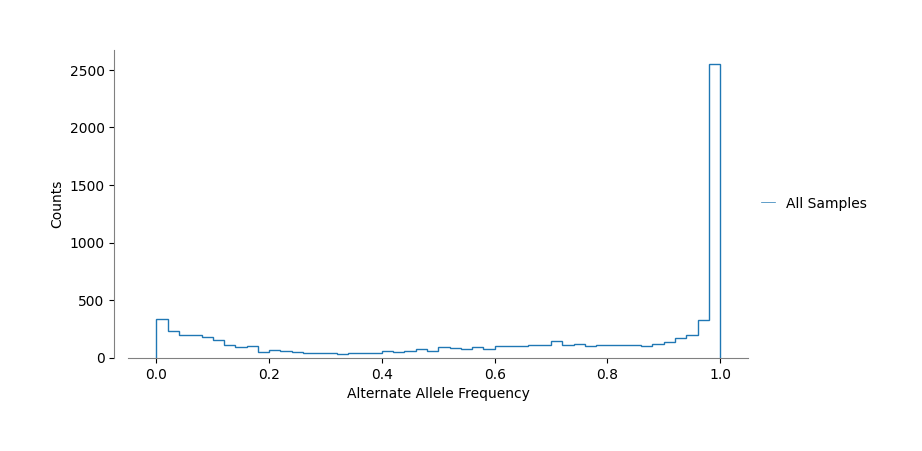

In [ ]:
fig,ax=plt.subplots(figsize=(8,4))
data=pd.read_csv('../data/allele_frequencies.tsv',sep='\t')
tmp = pd.Series(data.iloc[:,4:].values.flatten())
tmp.name='All Samples'
tmp.plot(kind='hist',histtype='step',bins=50,ax=ax,linewidth=1)
ax.set_xlabel('Alternate Allele Frequency')
ax.set_ylabel('Counts')
mod_hist_legend(ax)
clean_axes(ax)
plt.show()

- **Expected in a population**: Frequencies clustered at extremes (0 or 1)

> *"with also allele frequencies  deviating from the expected 0/1 pattern"*


# 🔬 Focusing on Single Nucleotide Variants

> To gain deeper insight into the evolutionary dynamics of our Cryptosporidium populations, we narrowed our analysis to focus specifically on Single Nucleotide Variants (SNVs).


```python
┌─────────────────────────────────────────────────────────┐
│ SNV CLUSTERING WORKFLOW                                 │
├─────────────────────────────────────────────────────────┤
│ 1. Filter dataset to retain only SNVs                   │    
│ 2. Normalize frequencies (divide by max frequency)      │
│ 4. Include only variants with >30% frequency            │
│    difference between any two samples                   │
│ 5. Perform hierarchical clustering                      │
│ 6. Visualize dendrogram                                 │
└─────────────────────────────────────────────────────────┘
```


step 1 starting variants: (1121, 11)
step 2 only snv variants: (511, 11)
selected variants: (129, 7)


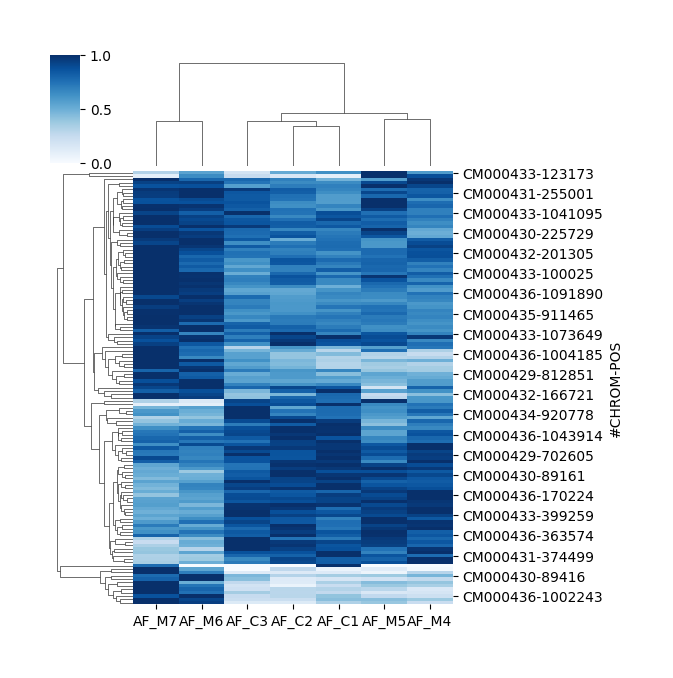

In [ ]:
data=pd.read_csv('../data/allele_frequencies.tsv',sep='\t')
print(f'step 1 starting variants: {data.shape}')
data=data[(data['ALT'].str.len()==1)]
print(f'step 2 only snv variants: {data.shape}')

clustering_data = data[['#CHROM','POS','AF_M7', 'AF_M5', 'AF_M6', 'AF_M4','AF_C3', 'AF_C2', 'AF_C1']]
clustering_data=clustering_data.set_index(['#CHROM','POS'])
clustering_data = clustering_data.divide(clustering_data.max(axis=1),axis=0)
clustering_max=clustering_data.max(axis=1)
clustering_min=clustering_data.min(axis=1)
clustering_data = clustering_data[(clustering_max-clustering_min)>0.3]
print('selected variants:', clustering_data.shape)
sns.clustermap(clustering_data,cmap='Blues',figsize=(6,6))
plt.savefig('../data/Allele_Frequency_SNVs.svg')
plt.savefig('../data/Allele_Frequency_SNVs.png')

## 🧬 Variant Observations
1. **No novel variant identified**:
> "Using our filtering strategy we could not detect SNV unique to one sample, but only frequency variations of the initial variant pool."
This observation has significant implications for outbreak investigations. Samples that are closely linked in a transmission chain may be more accurately characterized by analyzing the relative frequencies of variants rather than simply detecting their presence or absence under a diploid assumption.


## 🧬 Distinct Evolutionary Trajectories Revealed

The hierarchical clustering dendrogram revealed several patterns:

1. **Clear Host-Species Separation**: 
   > *"The clustering  segregated bovine and murine samples, suggesting host specific pressure on the Cryptosporidium population."*

2. **Temporal Evolution in Murine Hosts**:
   > *"The murine samples displayed a clear temporal progression, with M6 and M7 clustering distinctly from the earlier passages (M4-M5)."*

3. **Similarity Between Early Murine and Bovine Samples**:
   > *"The three bovine samples (C1-C3) showed greater similarity to the early murine passages (M4-M5) than to the later murine passages (M6-M7). 
   Bovine adaptation might be slower to kick in."*

4. **Caveats**:
   > *"We might be overinterpret results, the variation in frequency might be due to fluctuations/sampling in the population used for the M6 infection"*


## Determining Optimal Number of SNV Clusters
> Upon visual inspection of the hierarchical clustering dendrogram, we observed what appeared to be 3-4 distinct clusters of variants. To validate this initial observation and determine the optimal number of clusters more objectively, we employed two widely-used cluster validation techniques: the silhouette method and elbow analysis.

<Axes: title={'center': 'K-means Evaluation'}, xlabel='Number of Clusters (k)', ylabel='Normalized Score'>

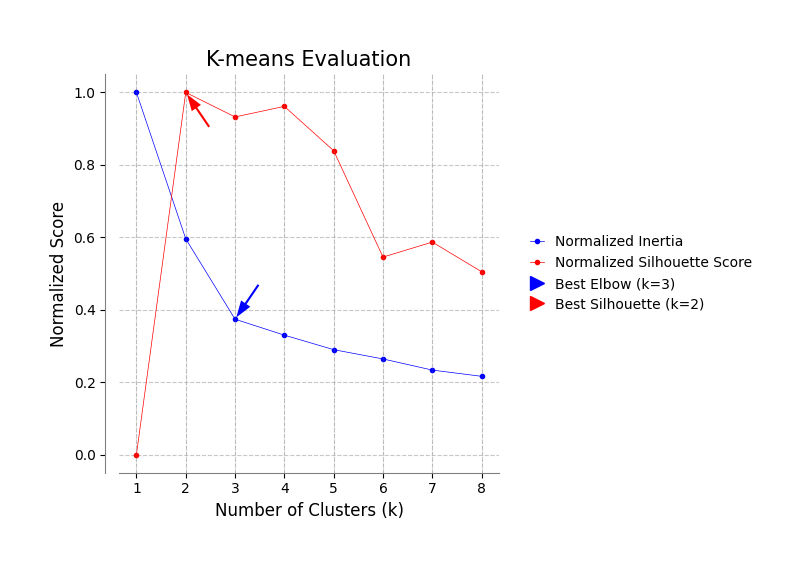

In [ ]:
fig, ax, inertia_values, silhouette_values = kmeans_cluster_analysis(
    clustering_data,
    cluster_sizes=[1,2,3,4,5,6,7,8],
    figsize=(6,5)
)
clean_axes(ax)

## Validation Results Support Three Main Clusters

> Our quantitative cluster validation analyses strongly confirm our initial visual assessment. The Silhouette analysis reveals comparable values for cluster numbers between 2 and 4, with scores declining steadily beyond 5 clusters. Meanwhile, the helbow plot displays a clear inflection point at 3 clusters.
Based on these complementary validation techniques, we can confidently determine that three represents the optimal number of clusters for our dataset. 

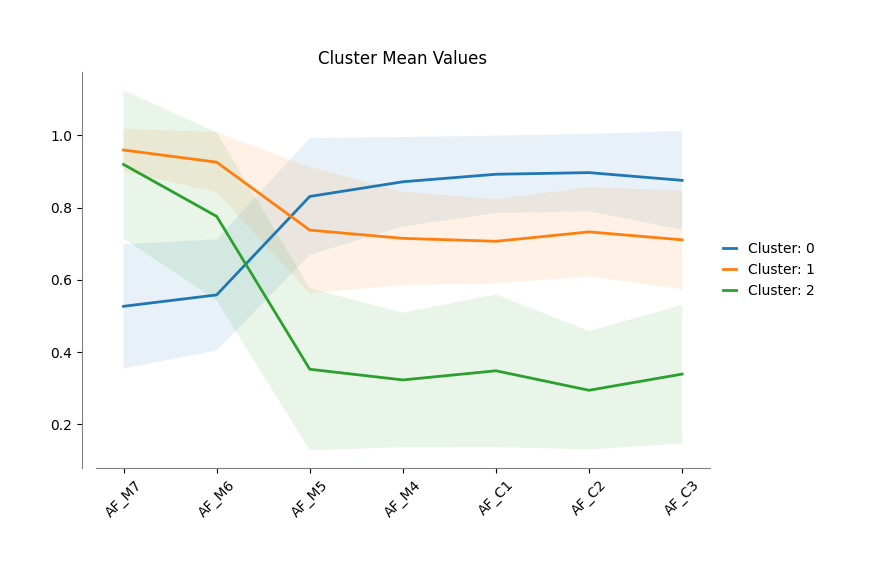

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(clustering_data[['AF_M7','AF_M6','AF_M5','AF_M4','AF_C1','AF_C2','AF_C3']])
clustering_data['cluster']=kmeans.labels_

fig, ax = plt.subplots(figsize=(8, 5))
for c in clustering_data.cluster.unique():
    cluster_data = clustering_data[clustering_data['cluster']==c][['AF_M7','AF_M6','AF_M5','AF_M4',
                              'AF_C1','AF_C2','AF_C3']]
    
    # Plot the mean
    means = cluster_data.mean()
    means.plot(ax=ax, label=f'Cluster: {c}', linewidth=2.0)
    
    # Add shaded area for std
    upper = means + cluster_data.std()
    lower = means - cluster_data.std()
    ax.fill_between(range(len(means)), lower, upper, alpha=0.1)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
if 'clean_axes' in globals():
    clean_axes(ax)
plt.title('Cluster Mean Values')
plt.xticks(range(7), ['AF_M7','AF_M6','AF_M5','AF_M4','AF_C1','AF_C2','AF_C3'], rotation=45)
plt.tight_layout()
plt.show()

## Evolutionary trajectories :

> When plotting the mean values of variants within each cluster, we observe three distinct evolutionary trajectories:
> - Dramatic Increase Cluster: Variants that show a substantial frequency increase in later mouse passages (M6 and M7)
> - Moderate Increase Cluster: Variants with a modest frequency increase in M6 and M7
> - Decrease Cluster: Variants that exhibit declining frequency in M6 and M7

Notably, across all three clusters, the variant frequencies in early mouse passages (M4 and M5) remain similar to those observed in all bovine passages (C1, C2, and C3). This pattern suggests that significant evolutionary divergence between host lineages begins after the second mouse passage, while the bovine lineage maintains greater genetic similarity to the original population.

# High Impact Variants: Tracking Protein-Altering Mutations
## 🧬 Decoding Functional Consequences

> With our variants  annotated using SnpEff, we can now delve deeper into their functional implications—moving beyond mere genomic positions to understand how these mutations potentially reshape Cryptosporidium biology.

In [ ]:
df_vcf = read_vcf( "../data/filtered_final.vcf")
df_vcf = df_vcf.set_index(['#CHROM','POS'])
df_vcf.head()

ID               REF  \
#CHROM   POS                          
CM000429 60867  .  TAAAAAAAAAAGATAT   
         60889  .          ACCCCACT   
         76625  .                 A   
         82019  .                 A   
         82192  .                 G   

                                                              ALT       QUAL  \
#CHROM   POS                                                                   
CM000429 60867  TAAAAAAAAAAAGATTT,TAAAAAAAAAAAGATAT,TAAAAAAAAA...  10088.400   
         60889                                          ACCCCCACT  11705.800   
         76625                                                  G    265.872   
         82019                                                  T   8192.190   
         82192                                                  A   6765.840   

               FILTER                                               INFO  \
#CHROM   POS                                                               
CM000429 60867   PASS  AB=0,0,0;ABP=0,0,0;AC=0,7,0;AF=0,1,0;AN=7;AO=1...   
         60889   PASS  AB=0;ABP=0;AC=7;AF=1;AN=7;AO=435;CIGAR=1M1I7M;...   
         76625   PASS  AB=0;ABP=0;AC=1;AF=0.142857;AN=7;AO=248;CIGAR=...   
         82019   PASS  AB=0;ABP=0;AC=7;AF=1;AN=7;AO=410;CIGAR=1X;DP=5...   
         82192   PASS  AB=0;ABP=0;AC=6;AF=0.857143;AN=7;AO=398;CIGAR=...   

                                    FORMAT  \
#CHROM   POS                                 
CM000429 60867  GT:GQ:DP:AD:RO:QR:AO:QA:GL   
         60889  GT:GQ:DP:AD:RO:QR:AO:QA:GL   
         76625  GT:GQ:DP:AD:RO:QR:AO:QA:GL   
         82019  GT:GQ:DP:AD:RO:QR:AO:QA:GL   
         82192  GT:GQ:DP:AD:RO:QR:AO:QA:GL   

                                                               M7  \
#CHROM   POS                                                        
CM000429 60867  2:138:82:9,2,67,2:9:296:2,67,2:24,2218,68:-172...   
         60889             1:137:90:9,81:9:295:81:2686:-215.126,0   
         76625          0:131:104:76,28:76:2560:28:952:0,-144.672   
         82019             1:160:98:9,89:9:306:89:2994:-241.841,0   
         82192          1:134:104:11,93:11:374:93:3124:-247.418,0   

                                                               M5  \
#CHROM   POS                                                        
CM000429 60867  2:138:46:3,2,35,1:3:100:2,35,1:24,1116,34:-91....   
         60889              1:137:53:1,50:1:34:50:1596:-140.656,0   
         76625           0:131:80:52,28:52:1738:28:930:0,-72.6994   
         82019           1:160:51:15,36:15:510:36:1186:-60.8115,0   
         82192           1:134:67:20,47:20:658:47:1598:-84.5836,0   

                                                               M4  \
#CHROM   POS                                                        
CM000429 60867  2:138:69:4,4,59,1:4:132:4,59,1:48,1980,34:-166...   
         60889              1:137:70:2,66:2:68:66:2184:-190.372,0   
         76625          0:131:84:50,34:50:1596:34:1156:0,-39.5691   
         82019           1:160:86:19,67:19:638:67:2240:-144.133,0   
         82192           1:134:75:25,50:25:842:50:1692:-76.4771,0   

                                                               M6  \
#CHROM   POS                                                        
CM000429 60867  2:138:82:14,2,62,1:14:461:2,62,1:24,2092,26:-1...   
         60889           1:137:82:11,70:11:359:70:2241:-169.324,0   
         76625           0:131:89:61,28:61:2066:28:944:0,-100.949   
         82019           1:160:90:15,75:15:488:75:2488:-179.952,0   
         82192          1:134:102:26,76:26:846:76:2568:-154.943,0   

                                                               C3  \
#CHROM   POS                                                        
CM000429 60867  2:138:57:5,1,45,1:5:163:1,45,1:12,1492,34:-119...   
         60889              1:137:45:5,40:5:169:40:1237:-96.064,0   
         76625          1:131:83:36,47:36:1216:47:1598:-34.3706,0   
         82019           1:160:70:26,44:26:

> We now add the vcf INFO to the dataset and extract variant effect

In [ ]:
#port INFO
clustering_data = clustering_data.join(df_vcf[['INFO']])

#deconstruct INFO
clustering_data = add_ann_info_to_df(clustering_data)
del clustering_data['INFO']
clustering_data.head()

AF_M7     AF_M5     AF_M6     AF_M4     AF_C3     AF_C2  \
#CHROM   POS                                                                  
CM000429 76625   0.475450  0.618085  0.555582  0.714792  1.000000  0.536094   
         82019   1.000000  0.777264  0.917603  0.857852  0.692135  0.679706   
         82192   1.000000  0.784465  0.833228  0.745520  0.527490  0.692847   
         702600  0.725550  0.837162  0.681081  0.922297  0.901888  0.861137   
         702605  0.722545  0.892645  0.694440  0.953358  1.000000  0.861506   

                    AF_C1  cluster        variant_type    impact    gene_id  \
#CHROM   POS                                                                  
CM000429 76625   0.772606        0  synonymous_variant       LOW   cgd1_340   
         82019   0.759930        1  synonymous_variant       LOW   cgd1_360   
         82192   0.673662        1    missense_variant  MODERATE   cgd1_360   
         702600  1.000000        0    missense_variant  MODERATE  cgd1_3190   
         702605  0.979373        0  synonymous_variant       LOW  cgd1_3190   

                allele  
#CHROM   POS            
CM000429 76625       G  
         82019       T  
         82192       A  
         702600      A  
         702605      A

## Variant Type Distribution and High-Impact Mutations

> After extracting SnpEff annotations, we analyzed the distribution of variant types across impact categories and clusters

In [ ]:
clustering_data[clustering_data['impact'].isin(
    ['LOW','MODERATE','HIGH'])].groupby(['impact','cluster']).size()

impact    cluster
HIGH      0           1
          1           1
LOW       0           9
          1          19
          2           6
MODERATE  0          23
          1          24
          2           5
dtype: int64

> Intriguingly, we identified only two HIGH impact SNV variants in our dataset, lets have a look 🔍

In [ ]:
clustering_data[clustering_data['impact']=='HIGH'].iloc[:,7:]

,,cluster,variant_type,impact,gene_id,allele
#CHROM,POS,,,,,
CM000435,620700,1,stop_gained,HIGH,cgd7_2620,A
CM000436,170586,0,stop_lost&splice_region_variant,HIGH,cgd8_670,C


> we created trajectory visualizations that track their frequencies across sequential passages in both lineages.

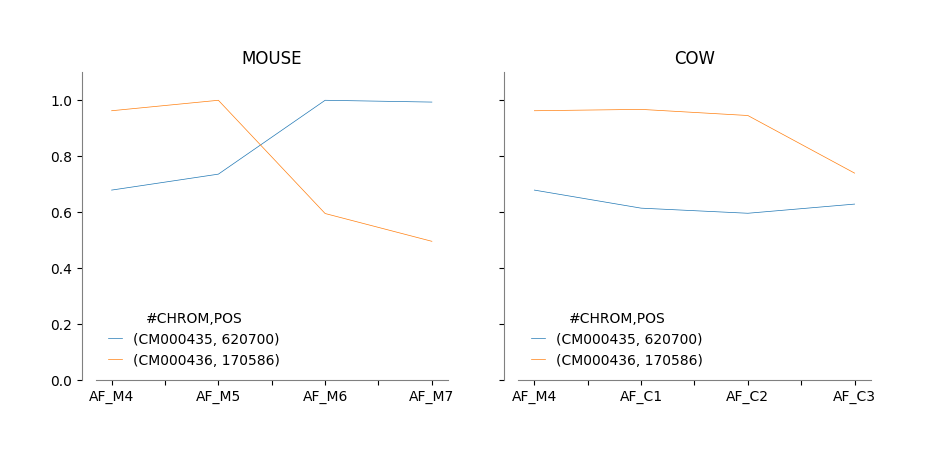

In [ ]:
fig,axes = plt.subplots(figsize = (10,4), ncols=2,sharey=True)
clustering_data[clustering_data['impact']=='HIGH'][['AF_M4','AF_M5','AF_M6','AF_M7']].T.plot(ax=axes[0])
clean_axes(axes[0]).set_title('MOUSE')
clustering_data[clustering_data['impact']=='HIGH'][['AF_M4','AF_C1','AF_C2','AF_C3']].T.plot(ax=axes[1])
clean_axes(axes[1]).set_title('COW')
plt.ylim(0,1.1)
plt.show()

### Key Variant Trajectories

One variant located at **CM000436:170586** (in gene **cgd8_670**) displays a  pattern of negative selection in both host lineages:

- In mouse passages: Frequency steadily decreases from  M4 to  M7
- In cow passages: Similar downward trend more evident at C3

The variant at **CM000435:620700** (in gene **cgd7_2620**) shows a host-dependent pattern:

- In mouse passages: Frequency increases 
- In cow passages: Frequency remains relatively stable


In [ ]:
#clustering_data[clustering_data['impact']=='MODERATE'].groupby('gene_id').size().sort_values().tail(5)

## Future Directions: Correlating Cluster Patterns with GO Annotations
> Having established three distinct clusters of SNV frequency patterns that correlate with host adaptation trajectories, we plan to extend this analysis by integrating Gene Ontology (GO) annotations. This functional enrichment approach will allow us to determine whether these evolutionary clusters represent coordinated changes in specific biological pathways or molecular functions.

## 🔍 Frequency Distribution Analysis SNVs

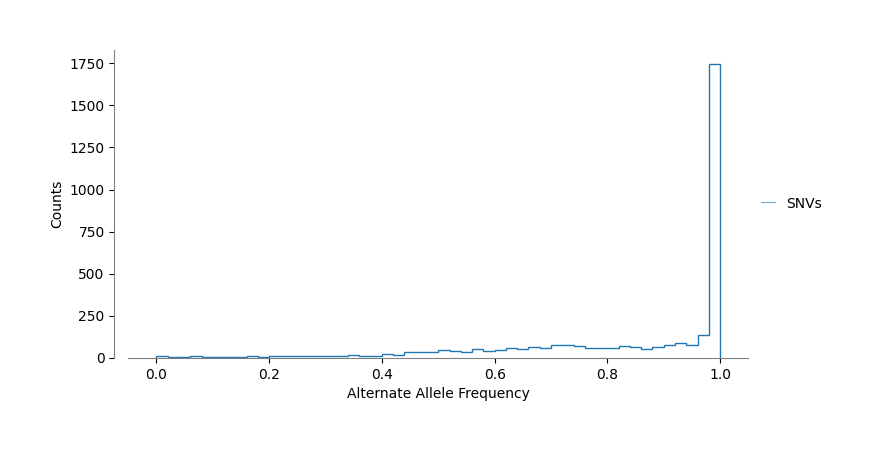

In [ ]:
fig,ax=plt.subplots(figsize=(8,4))
tmp = pd.Series(data.iloc[:,4:].values.flatten())
tmp.name='SNVs'
tmp.plot(kind='hist',histtype='step',bins=50,ax=ax,linewidth=1)
ax.set_xlabel('Alternate Allele Frequency')
ax.set_ylabel('Counts')
mod_hist_legend(ax)
clean_axes(ax)
plt.show()

## From SNVs to INDELs: Exploring Different Variant Dynamics

> While our overall frequency analysis revealed peaks near 0 and 1 across all variants, SNVs are predominantly clustered at higher frequencies (>0.4). This observation raises an important question: what's happening with INDELs to create this contrast? To understand this difference, we next focused specifically on INDEL frequency distributions, which might reveal distinct evolutionary dynamics for these structural variants compared to point mutations.

# 🔬 Focusing on INDELS
> Having established clear evolutionary patterns through SNV analysis, we extended our investigation to insertions and deletions (INDELs) using the same strategy

step 1 starting variants: (1121, 11)
step 2 only snv variants: (610, 11)
selected variants: (349, 7)


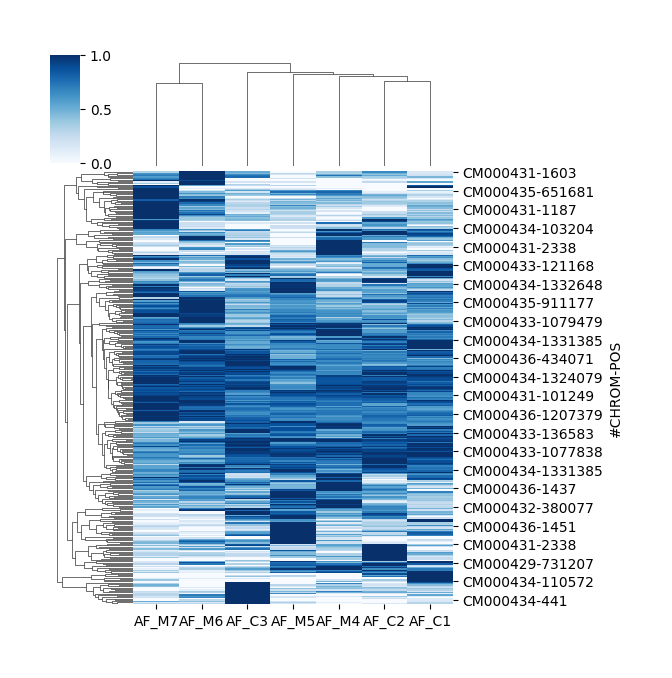

In [ ]:
data=pd.read_csv('../data/allele_frequencies.tsv',sep='\t')
print(f'step 1 starting variants: {data.shape}')
data=data[(data['ALT'].str.len()!=1)]
print(f'step 2 only snv variants: {data.shape}')

clustering_data = data[['#CHROM','POS','AF_M7', 'AF_M5', 'AF_M6', 'AF_M4','AF_C3', 'AF_C2', 'AF_C1']]
clustering_data=clustering_data.set_index(['#CHROM','POS'])
clustering_data = clustering_data.divide(clustering_data.max(axis=1),axis=0)
clustering_max=clustering_data.max(axis=1)
clustering_min=clustering_data.min(axis=1)
clustering_data = clustering_data[(clustering_max-clustering_min)>0.3]

print('selected variants:', clustering_data.shape)
sns.clustermap(clustering_data,cmap='Blues',figsize=(6,6))
plt.savefig('../data/Allele_Frequency_INDELs.svg')
plt.savefig('../data/Allele_Frequency_INDELs.png')

## 🧬 Distinct Clustering Patterns in INDELs

When applying our clustering strategy to INDELs, we observed strikingly different patterns from those seen with SNVs

>*"The most striking feature of our INDEL analysis is the emergence of sample specific variant clusters"*  or in ther words, sample specific groups of INDELs



## 🔍 Frequency Distribution Analysis SNVs

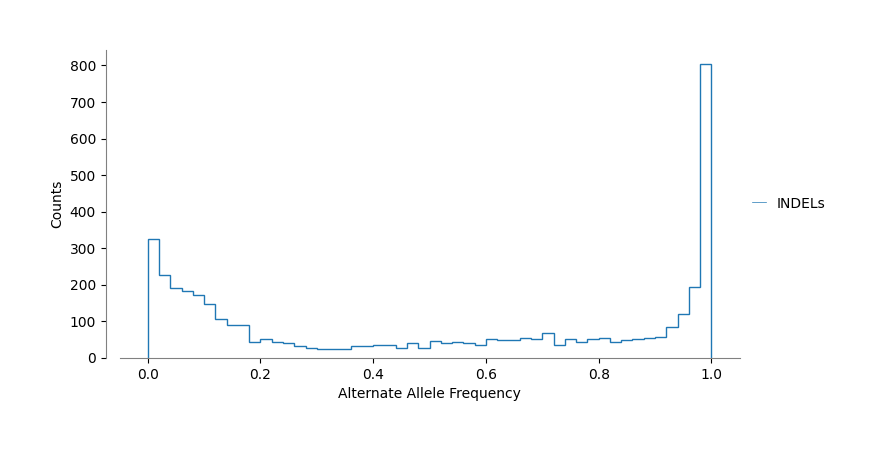

In [ ]:
fig,ax=plt.subplots(figsize=(8,4))
tmp = pd.Series(data.iloc[:,4:].values.flatten())
tmp.name='INDELs'
tmp.plot(kind='hist',histtype='step',bins=50,ax=ax,linewidth=1)
ax.set_xlabel('Alternate Allele Frequency')
ax.set_ylabel('Counts')
mod_hist_legend(ax)
clean_axes(ax)
plt.show()

## 📊 Accelerated INDEL Evolution

> *"The predominance of low-frequency INDELs compared to the SNVs frequencies suggests fundamentally different evolutionary dynamics: while SNVs appear to undergo gradual selection toward fixation, INDELs display a pattern of rapid emergence and turnover, generating a diverse array of transient subpopulations within each sample."*

> Indels do not appear to reconstruct the infection hystory as well as SNVs 

# Genome-Wide Distribution: Mapping Variants Across the Cryptosporidium Genome

## 🔍 Taking a Broader Perspective

> Having explored the dynamics of both SNVs and INDELs through clustering analyses, we stepped back to examine the holistic picture of where these variants are distributed across the Cryptosporidium genome.


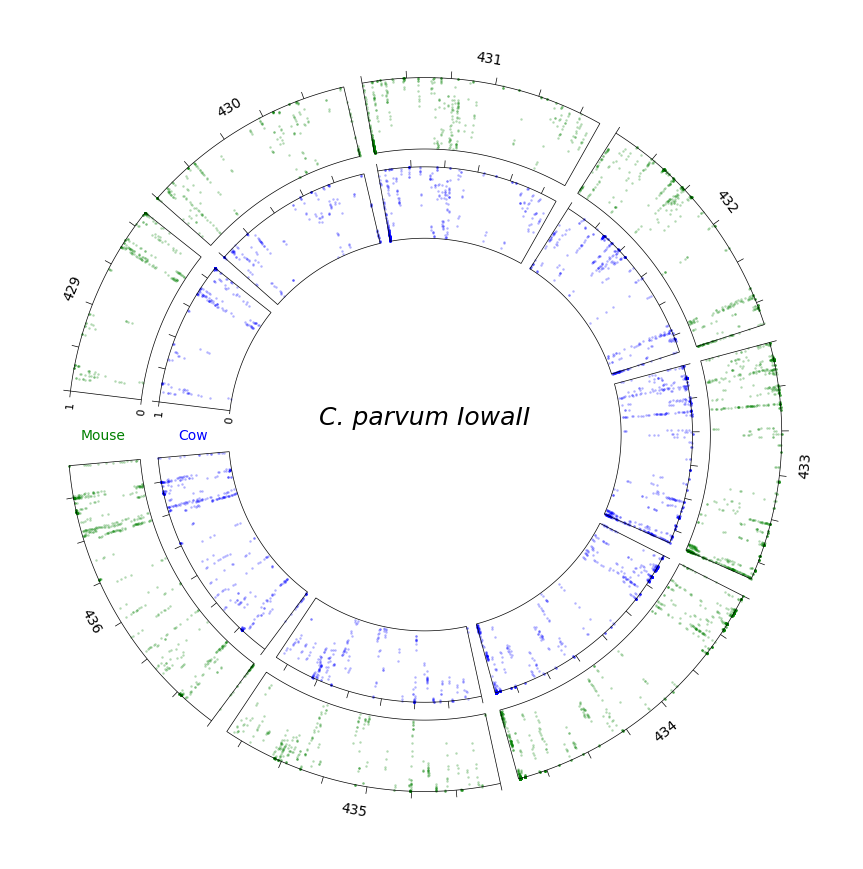

In [ ]:
data=pd.read_csv('../data/allele_frequencies.tsv',sep='\t')
make_circos_plot(data)

## 🧬 Genomic Distribution Patterns

The circular genome plot revealed several striking patterns:

> *"The distribution of variants across the Cryptosporidium genome is strikingly non-random, with clear hotspots of both SNVs and INDELs congregating in specific genomic regions other then close to the telomers as alredy observed in other study"*



## 🧬 Expanding Comparative Analysis


> We plan to compare our samples with other environmental and outbreak-related Cryptosporidium genome sequencing projects.

## Reproducibility and Availability

The complete analysis pipeline is available as a Python package in our GitHub repository

### Installation

```bash
pip install git+https://github.com/mtinti/cryptosporidium_host_adaptation.git
```

### Dependencies

This pipeline was developed and tested with:
- samtools (Version: 1.21)
- bcftools (Version: 1.21)

### Interactive Analysis

For interactive exploration and reproducibility, we provide Jupyter notebooks accessible through MyBinder. 
> The computational environment includes all necessary dependencies pre-configured.


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()